# Analisis dan Visualisasi Hasil Eksperimen

**Tujuan Notebook:**
1. Memuat metrik performa dan kecepatan inferensi dari model XGBoost dan TabNet.
2. Membuat tabel perbandingan untuk disajikan dalam paper.
3. Memuat data histori pelatihan dari kedua model.
4. Membuat visualisasi grafik loss dan akurasi untuk analisis perilaku model.
5. Menyediakan platform untuk menarik kesimpulan akhir.

In [1]:
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Atur gaya plot agar terlihat lebih profesional
sns.set_theme(style="whitegrid", palette="muted")
plt.style.use('seaborn-v0_8-whitegrid')

print("Pustaka yang dibutuhkan telah diimpor.")

Pustaka yang dibutuhkan telah diimpor.


In [2]:
# Pastikan Google Drive sudah di-mount
try:
    from google.colab import drive
    drive.mount('/content/drive')
except ImportError:
    print("Bukan di lingkungan Colab, pastikan path sudah benar.")

# Path ke direktori output tempat Anda menyimpan semua hasil
OUTPUT_DIR = "/content/drive/My Drive/datasets/Phishing_Detection_Dataset/outputs/"

Mounted at /content/drive


## Load Hasil Eksperimen

In [8]:
def load_json_data(filepath):
    """Fungsi helper untuk memuat file JSON dengan penanganan error."""
    try:
        with open(filepath, 'r') as f:
            data = json.load(f)
        print(f"✅ Berhasil memuat: {os.path.basename(filepath)}")
        return data
    except FileNotFoundError:
        print(f"❌ Gagal: File tidak ditemukan di {filepath}")
        return None

# Path lengkap ke setiap file hasil
xgb_results_path = os.path.join(OUTPUT_DIR, 'xgb_results.json')
tabnet_results_path = os.path.join(OUTPUT_DIR, 'tabnet_results.json')
xgb_history_path = os.path.join(OUTPUT_DIR, 'xgb_history.json')
tabnet_history_path = os.path.join(OUTPUT_DIR, 'tabnet_history.json')

# Muat semua data
xgb_results = load_json_data(xgb_results_path)
tabnet_results = load_json_data(tabnet_results_path)
xgb_history = load_json_data(xgb_history_path)
tabnet_history = load_json_data(tabnet_history_path)

✅ Berhasil memuat: xgb_results.json
✅ Berhasil memuat: tabnet_results.json
✅ Berhasil memuat: xgb_history.json
✅ Berhasil memuat: tabnet_history.json


## Tabel Analisis Performa Model

In [16]:
print("Tabel 1: Perbandingan Metrik Performa Model Final pada Data Uji")

metrics_list = []
if xgb_results and 'gpu_metrics' in xgb_results:
    metrics_list.append(xgb_results['gpu_metrics'])
if tabnet_results and 'gpu_metrics' in tabnet_results:
    metrics_list.append(tabnet_results['gpu_metrics'])

if metrics_list:
    # Buat DataFrame dari daftar metrik
    performance_df = pd.DataFrame(metrics_list)
    # Hapus kolom yang tidak relevan untuk tabel ini
    performance_df = performance_df.drop(columns=['Device'], errors='ignore')

    performance_df = performance_df.drop(columns=['Inference Time (ms/sample)'], errors='ignore')
    # Jadikan 'Model' sebagai indeks tabel
    performance_df = performance_df.set_index('Model')
    # Tampilkan tabel dengan format yang rapi (4 angka desimal)
    display(performance_df.style.format("{:.4f}"))
else:
    print("Data metrik tidak tersedia untuk ditampilkan.")

Tabel 1: Perbandingan Metrik Performa Model Final pada Data Uji


,Accuracy,Precision,Recall,F1-score
Model,,,,
XGBoost (Tuned),0.9550,0.9679,0.9391,0.9533
TabNet (Tuned),0.9059,0.9295,0.8737,0.9007


## Perbandingan Kecepatan Inferensi

In [12]:
print("Tabel 2: Perbandingan Kecepatan Inferensi Rata-rata per Sampel (ms)")

inference_data = []

# Kumpulkan data dari XGBoost
if xgb_results:
    if xgb_results.get('gpu_metrics'):
        inference_data.append({
            'Model': 'XGBoost (Tuned)',
            'Device': 'GPU',
            'Waktu (ms/sampel)': xgb_results['gpu_metrics'].get('Inference Time (ms/sample)')
        })
    if xgb_results.get('cpu_metrics'):
        inference_data.append({
            'Model': 'XGBoost (Tuned)',
            'Device': 'CPU',
            'Waktu (ms/sampel)': xgb_results['cpu_metrics'].get('Inference Time (ms/sample)')
        })

# Kumpulkan data dari TabNet
if tabnet_results:
    if tabnet_results.get('gpu_metrics'):
        inference_data.append({
            'Model': 'TabNet (Tuned)',
            'Device': 'GPU',
            'Waktu (ms/sampel)': tabnet_results['gpu_metrics'].get('Inference Time (ms/sample)')
        })
    if tabnet_results.get('cpu_metrics'):
         inference_data.append({
            'Model': 'TabNet (Tuned)',
            'Device': 'CPU',
            'Waktu (ms/sampel)': tabnet_results['cpu_metrics'].get('Inference Time (ms/sample)')
        })

if inference_data:
    inference_df = pd.DataFrame(inference_data)
    # Buat pivot table untuk perbandingan yang mudah
    pivot_df = inference_df.pivot(index='Model', columns='Device', values='Waktu (ms/sampel)')
    display(pivot_df.style.format("{:.6f}"))
else:
    print("Data kecepatan inferensi tidak tersedia.")

Tabel 2: Perbandingan Kecepatan Inferensi Rata-rata per Sampel (ms)


Device,CPU,GPU
Model,,
TabNet (Tuned),0.034551,0.026675
XGBoost (Tuned),0.026744,0.000804


## Visualisasi History Pelatihan

Menampilkan Grafik Histori Pelatihan...



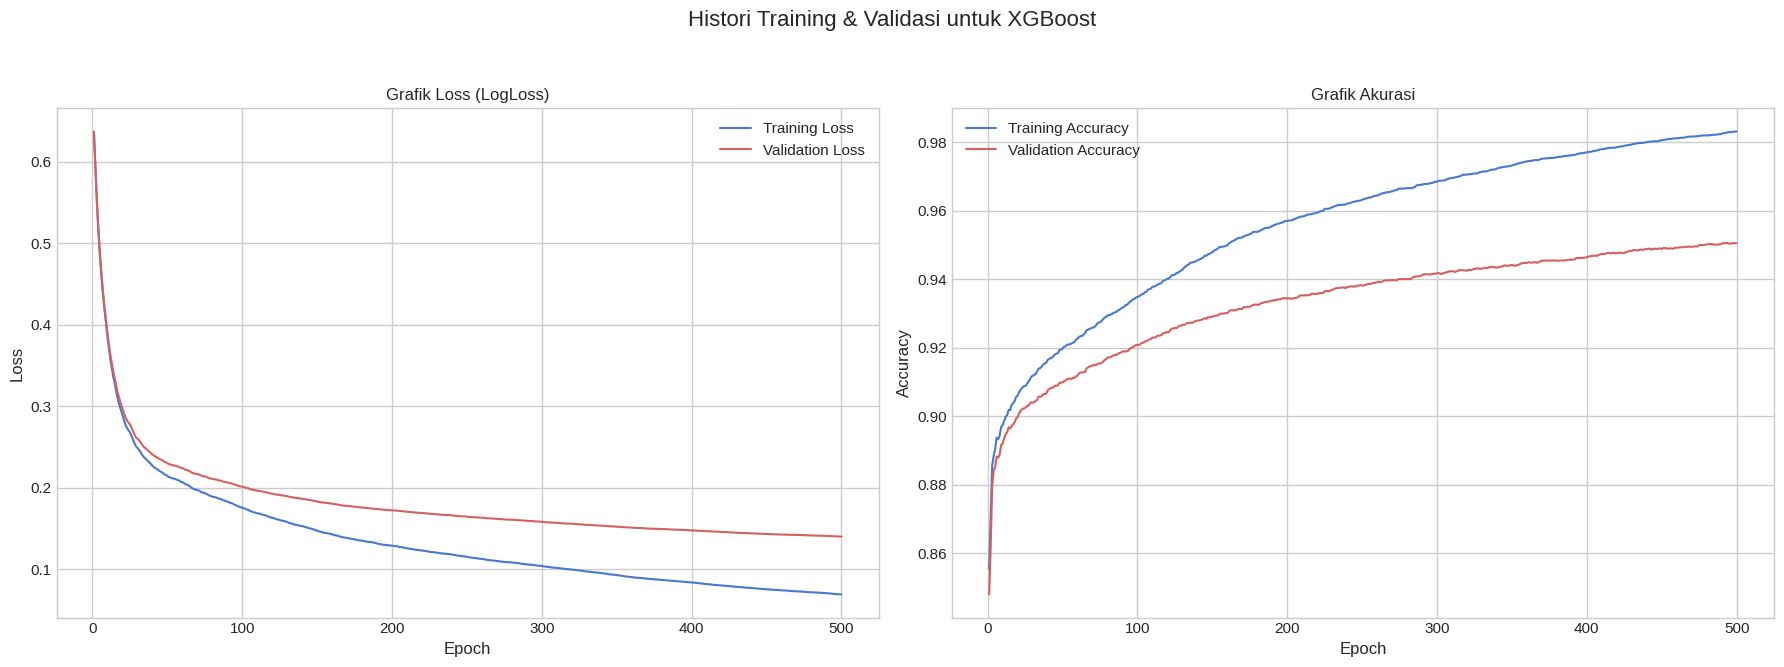

In [14]:
# --- Fungsi untuk XGBoost ---
def plot_xgb_history(history, model_name="XGBoost"):
    if not history:
        print(f"Data histori untuk {model_name} tidak tersedia.")
        return
    train_loss = history['validation_0']['logloss']
    val_loss = history['validation_1']['logloss']
    train_acc = [1 - x for x in history['validation_0']['error']]
    val_acc = [1 - x for x in history['validation_1']['error']]
    epochs = range(1, len(train_loss) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    fig.suptitle(f'Histori Training & Validasi untuk {model_name}', fontsize=16)

    ax1.plot(epochs, train_loss, 'b-', label='Training Loss')
    ax1.plot(epochs, val_loss, 'r-', label='Validation Loss')
    ax1.set_title('Grafik Loss (LogLoss)')
    ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)

    ax2.plot(epochs, train_acc, 'b-', label='Training Accuracy')
    ax2.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    ax2.set_title('Grafik Akurasi'); ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy'); ax2.legend(); ax2.grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()

# --- Fungsi untuk TabNet ---
def plot_tabnet_history(history, model_name="TabNet"):
    if not history:
        print(f"Data histori untuk {model_name} tidak tersedia.")
        return
    train_loss = history.get('train_logloss', [])
    val_loss = history.get('val_logloss', [])
    train_acc = history.get('train_accuracy', [])
    val_acc = history.get('val_accuracy', [])

    if not train_loss:
        print("Data loss tidak ditemukan dalam histori TabNet.")
        return

    epochs = range(1, len(train_loss) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    fig.suptitle(f'Histori Training & Validasi untuk {model_name}', fontsize=16)

    ax1.plot(epochs, train_loss, 'b-', label='Training Loss')
    ax1.plot(epochs, val_loss, 'r-', label='Validation Loss')
    ax1.set_title('Grafik Loss (LogLoss)'); ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)

    if train_acc and val_acc:
        ax2.plot(epochs, train_acc, 'b-', label='Training Accuracy')
        ax2.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
        ax2.set_title('Grafik Akurasi'); ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy'); ax2.legend(); ax2.grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()

# --- Panggil Fungsi Plot ---
print("Menampilkan Grafik Histori Pelatihan...\n")
plot_xgb_history(xgb_history)
# plot_tabnet_history(tabnet_history)

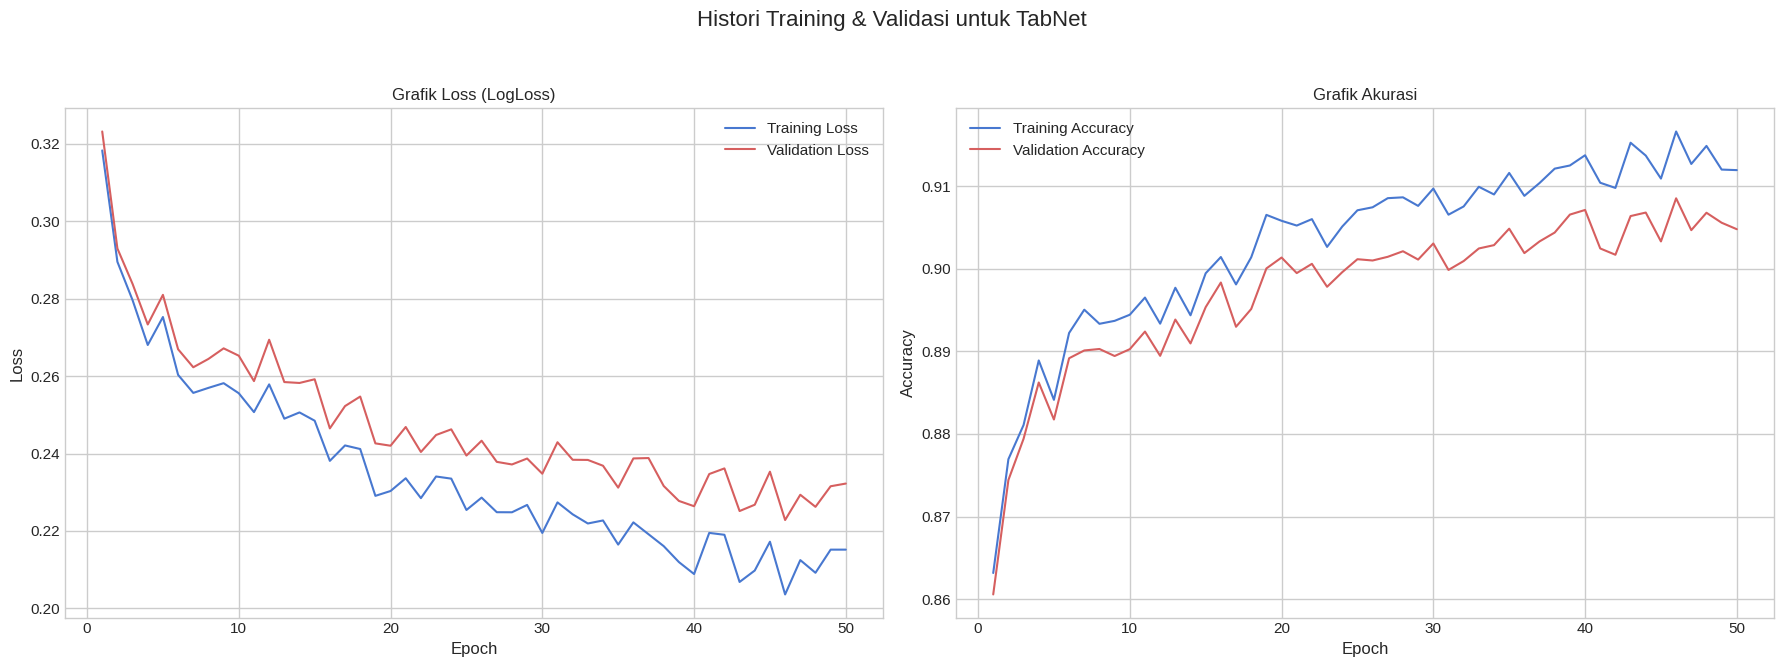

In [15]:
plot_tabnet_history(tabnet_history)